# Poisson-BVP-2

This notebook implements the BCGP experiments for Poisson-BVP-2 from Section 5.2.2 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices, vmap

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params, PARAM_OPTIONS_DICT as param_gen_options
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True) 
# config.update("jax_debug_nans", False) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

### Specify settings of the experiments

In [4]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 1664

# only BCGP supported for this example
GP_TYPE = 'bcgp'
assert GP_TYPE in ['bcgp'] 

# number of f space observations to use for inference
Nf: int = 1000

# path to subdirectory in /data where Heat-IBVP-1 data is saved
data_save_dir: str = f'poissonBVP2'
data_save_dir_full = os.path.join('data', data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels for collocation points
NOISE_INIT = jnp.array([0.1])

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = True

# options for model training
N_TRAIN_STEPS: int = 4000
N_RESTARTS: int    = 1
LR_INIT: float     = 0.025
VERBOSE: bool      = True

### Specify boundary-constrained mean and kernel functions

The BCGP mean $(\tilde{m})$ and kernel $(\tilde{k})$ functions are designed to ensure that the BCGP exactly satisfies the Dirichlet boundary conditions for $x \in \partial \Omega$. 

The mean function is simply set to zero

In [5]:
mean_fn= lambda p, loc: loc[0]*0.

The kernel takes the form

\begin{equation*}
	\tilde{k}([x,y],[x',y']) = \phi(x,y) \phi(x',y') k([x,y],[x',y']).
\end{equation*}


The ADF $\phi$ is found in two stages. Firstly, individual ADFs are defined for each of the five line segments which form the boundary $\partial \Omega$. This is done as below, the details of which are explained in  Appendix A.4 of the manuscript.

In [6]:
def dist(x1,y1,x2,y2):
    return jnp.sqrt((x2-x1)**2+(y2-y1)**2)

def linseg_dist(loc: Array, segment: Array):
    # returns distance from loc to line segment
    # with end points contained in segment
    # based on code from https://arxiv.org/abs/2104.08426

    x, y = loc
    x1,y1,x2,y2 = segment
    
    L = dist(x1,y1,x2,y2)
    
    xc = (x1+x2)/2.
    yc = (y1+y2)/2.
    
    h = (1/L)*((x-x1)*(y2-y1) - (y-y1)*(x2-x1))
    t = (1/L)*((L/2.)**2-dist(x,y,xc,yc)**2)
    
    tmp_val = jnp.sqrt(t**2+h**4)
    
    return jnp.sqrt(h**2 + (1/4.)*(tmp_val-t)**2)

# vmap to evaluate ADF for each boundary line segment at the same time
linseg_dist_vmap = vmap(linseg_dist, in_axes=[None,0])

Then, the ADF $\phi$ is found using the R-equivalence join from Eq.(25) of the manuscript:

In [7]:
# coords of the end points of the exterior line segments
exterior_surfaces = jnp.load(f'{data_save_dir_full}/geometryData/exterior_line_segments.npy')

# R-equivalence join
def phi(loc: Array):
    phi_vals = linseg_dist_vmap(loc, exterior_surfaces)
    phi_inv_sum = jnp.sum(1./phi_vals)
    return 1./phi_inv_sum

$\tilde{k}$ can now be defined

In [8]:
BASE_KERNEL = jax_pigp.kernels.squared_exponential

def kernel_fn(params: dict, loc1: Array, loc2: Array):

    k_params = params['kernel_params_1']

    base_kernel_val = BASE_KERNEL(k_params, loc1, loc2)

    cov_val = phi(loc1)*phi(loc2)*base_kernel_val

    return cov_val.squeeze()

### Specify Poisson differential operator

Recall that Poisson's equation over two spatial dimensions takes the form

$$\mathcal{L}_{x,y}[u] =   -\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) = f = 4.$$

##### Implementation: 

* $f$ is returned by calling the ``apply_PDE`` function defined below


In [9]:
def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Poisson PDE to input fn at specified argnum
    """

    # the Hessian function
    _, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):

        # Laplacian (i.e. sum of second spatial derivatives) is the trace of the Hessian matrix 
        uxx_val, uyy_val = jnp.diag(Hfn(params, loc1, *loc2))
        
        return -(uxx_val + uyy_val)
        
    return PDE 

linear_operators = [apply_PDE]

### Store settings

Store optimisation options in a dictionary

In [10]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['theta_transform'] = THETA_TRANSFORM
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [11]:
param_gen_options['input_dim']       = [INPUT_DIM]
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [12]:
results_save_dir = os.path.join('results', data_save_dir, f'{GP_TYPE}_Nf_{Nf}')
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [13]:
train_data, test_data = load_data(data_save_dir_full, Nf=Nf)

Check shapes of train and test data

In [14]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((1000, 1), (1228, 1), [(1000, 2)])

### Plot ADF

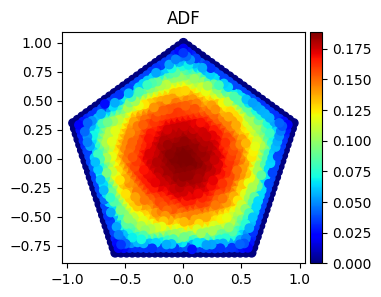

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

phi_vals = vmap(phi)(test_data.Xs)
make_scatter_heatmap(ax, test_data.Xs, phi_vals, "ADF")

plt.savefig(os.path.join(results_save_dir, 'ADF.pdf'))

### Initialise PIGP model

In [16]:
poisson_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
poisson_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(poisson_kernel_fns, poisson_mean_fns)

### Initialise learner for model training

In [17]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [18]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [17.01488375]
ls: [2.29811498 4.25182524]
alpha: [7.76696883]

noise_std: [0.1]


Objective function value for initial parameters

In [19]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-21323.19354816, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [20]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(21323.19354816, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([-152.17101884], dtype=float64),
   'ls': Array([3647.71467991, 1517.03724645], dtype=float64)},
  'noise_std': Array([-37243.93744382], dtype=float64)})

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [21]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [22]:
print(f'gp_type={GP_TYPE}, Nf={Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nf=1000, n_steps=4000, n_restarts=1

Restart 0: beginning training for 4000 steps
(0): 9226.2354, noise_std_vals = [1.02e-01]
(160): -116.8436, noise_std_vals = [2.05e-01]
(320): -480.1289, noise_std_vals = [1.17e-01]
(480): -605.0965, noise_std_vals = [7.96e-02]
(640): -685.8363, noise_std_vals = [5.60e-02]
(800): -691.6515, noise_std_vals = [5.14e-02]
(960): -692.5120, noise_std_vals = [5.13e-02]
(1120): -693.5384, noise_std_vals = [5.13e-02]
(1280): -694.7617, noise_std_vals = [5.12e-02]
(1440): -696.2175, noise_std_vals = [5.12e-02]
(1600): -697.9456, noise_std_vals = [5.11e-02]
(1760): -699.9742, noise_std_vals = [5.11e-02]
(1920): -702.2622, noise_std_vals = [5.10e-02]
(2080): -704.5246, noise_std_vals = [5.09e-02]
(2240): -706.0445, noise_std_vals = [5.07e-02]
(2400): -706.4779, noise_std_vals = [5.06e-02]
(2560): -706.5150, noise_std_vals = [5.06e-02]
(2720): -706.5162, noise_std_vals = [5.06e-02]
(2880): -706.5162, noise_std_vals = [5.06e-02]
(3040): -706.5162, n

Uncomment below to continue training from existing parameter values:

In [23]:
# gp_learner.train(opt_options["n_steps"])
# gp_learner.params_best = gp_learner.params.copy()

### Plot training results

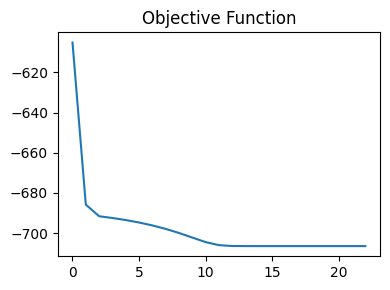

In [24]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.15)

plot_lc(ax, gp_learner.obj_list[begin_at:], 'Objective Function')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [25]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [7.6513494]
amp: [2.59074349]
ls: [0.23530709 0.23716534]

noise_std: [0.05057351]


Can load pre-trained parameters by uncommenting the below

In [26]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [27]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nf={Nf}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma)**.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 's_pred.npy'), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

Posterior results for bcgp, Nf=1000, Ns=1228
mean/max loss: 7.215748e-05/1.475e-03


### Plots of posterior prediction

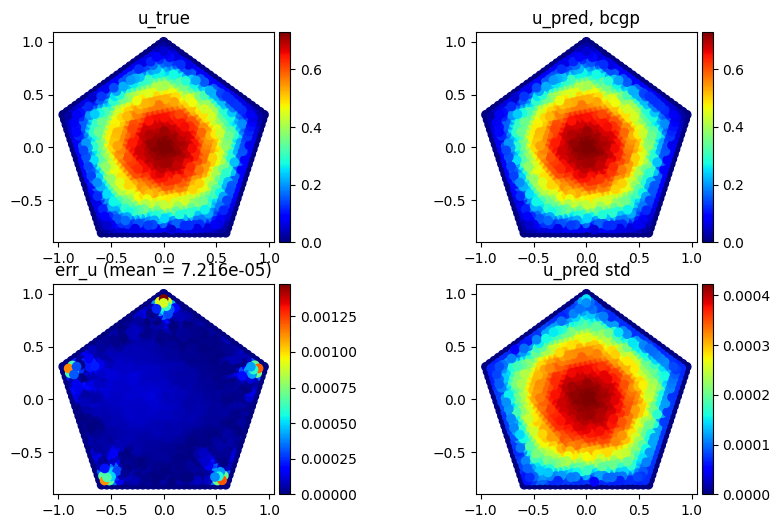

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=TWO_BY_TWO_FIGSIZE)

make_scatter_heatmap(axes[0,0], test_data.Xs, test_data.us, title='u_true')
make_scatter_heatmap(axes[0,1], test_data.Xs, mu, title=f'u_pred, {GP_TYPE}')
make_scatter_heatmap(axes[1,0], test_data.Xs, abs_losses, title=f'err_u (mean = {abs_losses.mean():.3e})')
make_scatter_heatmap(axes[1,1], test_data.Xs, s, title=f'u_pred std')

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))